# DSMCER - Notebook 8: SML Model Zoo and Boosting

0. Tracking carbon
1. Linear Models
    1. Linear Regression
    2. Logistic Regression
    3. Lasso Regression
    4. Ridge Regression
2. K-Nearest Neighbor
3. Decision Tree
    1. Random Forest
    2. _Exercise_: Cost of Random forest 
4. Kernel Methods
    1. Kernel Ridge
    3. Support Vector Machine
    2. Gaussian Processes
5. Boosting
    1. Gradient Boosting
    2. XGBoost

In [20]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble

# ! NEW
import codecarbon

***
***

<font size=5><center>The goal of SML is the same regardless of architecture:

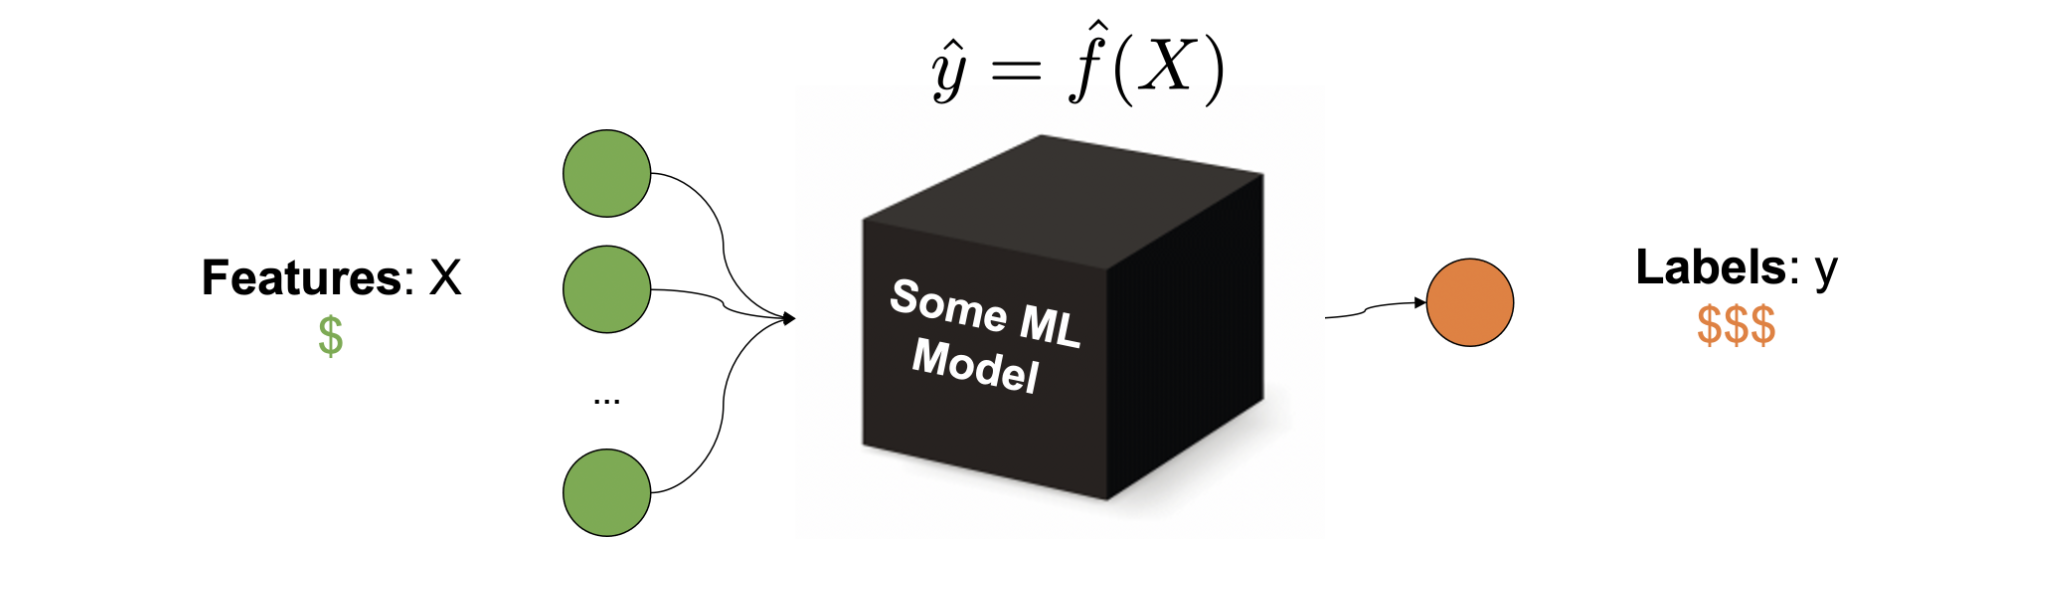

<font size=5><center>The nuance comes in developing the model ($\hat{f}$). We have to chose an architecture (hyperparameters) and train the model to determine the parameters:

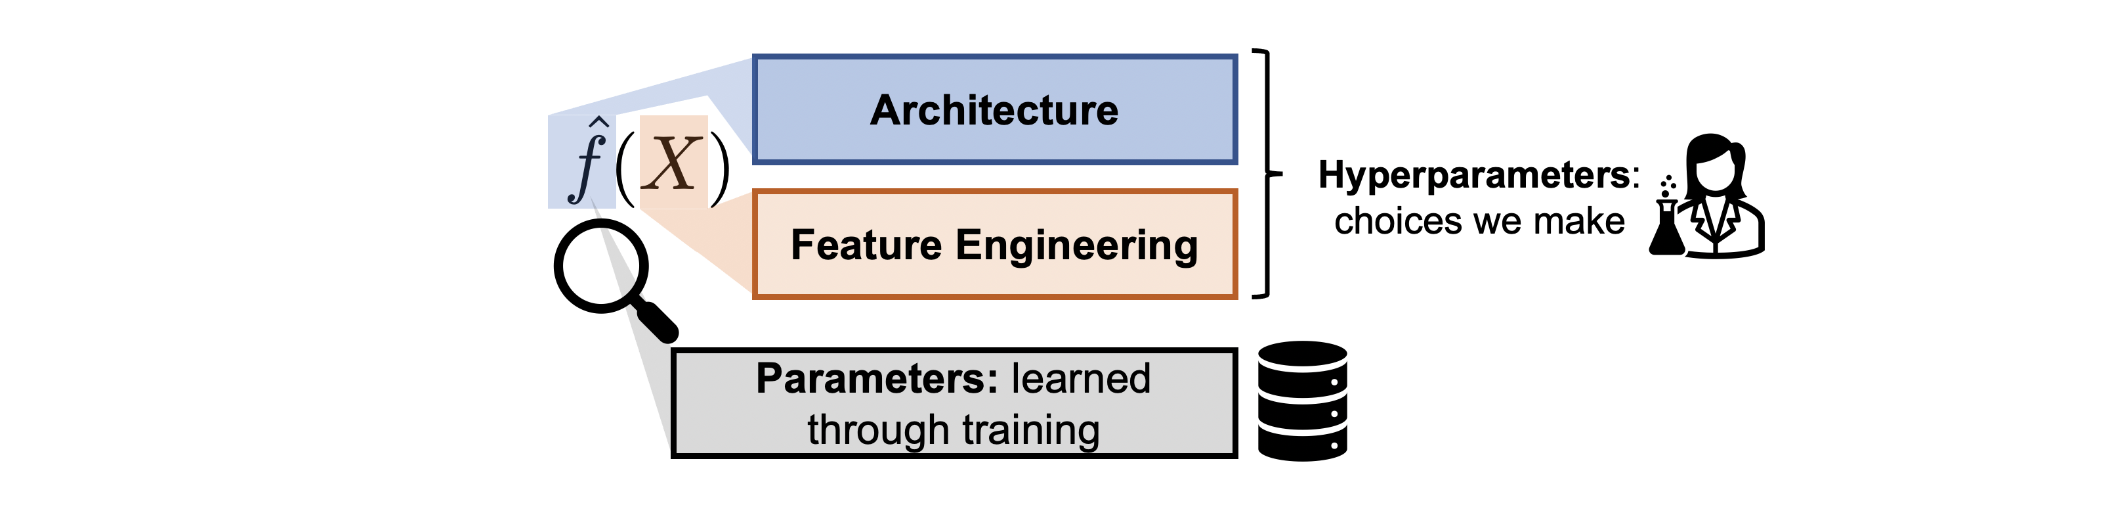

<font size=5><center>Thusfar we have only used simple models (Linear and KNN). __Its about time to introduce some more complex architectures.__

In [2]:
# load the data by downloading it
df = pd.read_csv('HCEPDB_moldata.zip').sample(5000, random_state=200)

<font size=5><center>Let's test these models on HCEPDB data, and use __all of the continuous features__ to predict LUMO to HOMO gap.

In [3]:
df['gap'] = df['e_lumo_alpha'] - df['e_homo_alpha']


In [4]:
df = df[['mass', 'pce', 'voc', 'jsc', 'gap']]

<font size=4> Let's do some basic data preprocessing

In [5]:
dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

In [6]:
dev_X = dev[['mass', 'pce', 'voc', 'jsc']].values
test_X = test[['mass', 'pce', 'voc', 'jsc']].values

dev_y_regr = dev['gap'].values.reshape(-1,1)
test_y_regr = test['gap'].values.reshape(-1,1)

<font size=4> For classification - __let's choose a binary classification of the energy gap being greater than or less than 1.5__.

In [7]:
dev_y_class = dev_y_regr > 1.5
test_y_class = test_y_regr > 1.5

<font size=4> standardize features...

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.transform(test_X)

***

## 0. Tracking Carbon

<font size=4>Remember how running code takes time? __We can estimate the amount of carbon__ used with a tool called `codecarbon`. https://codecarbon.io/

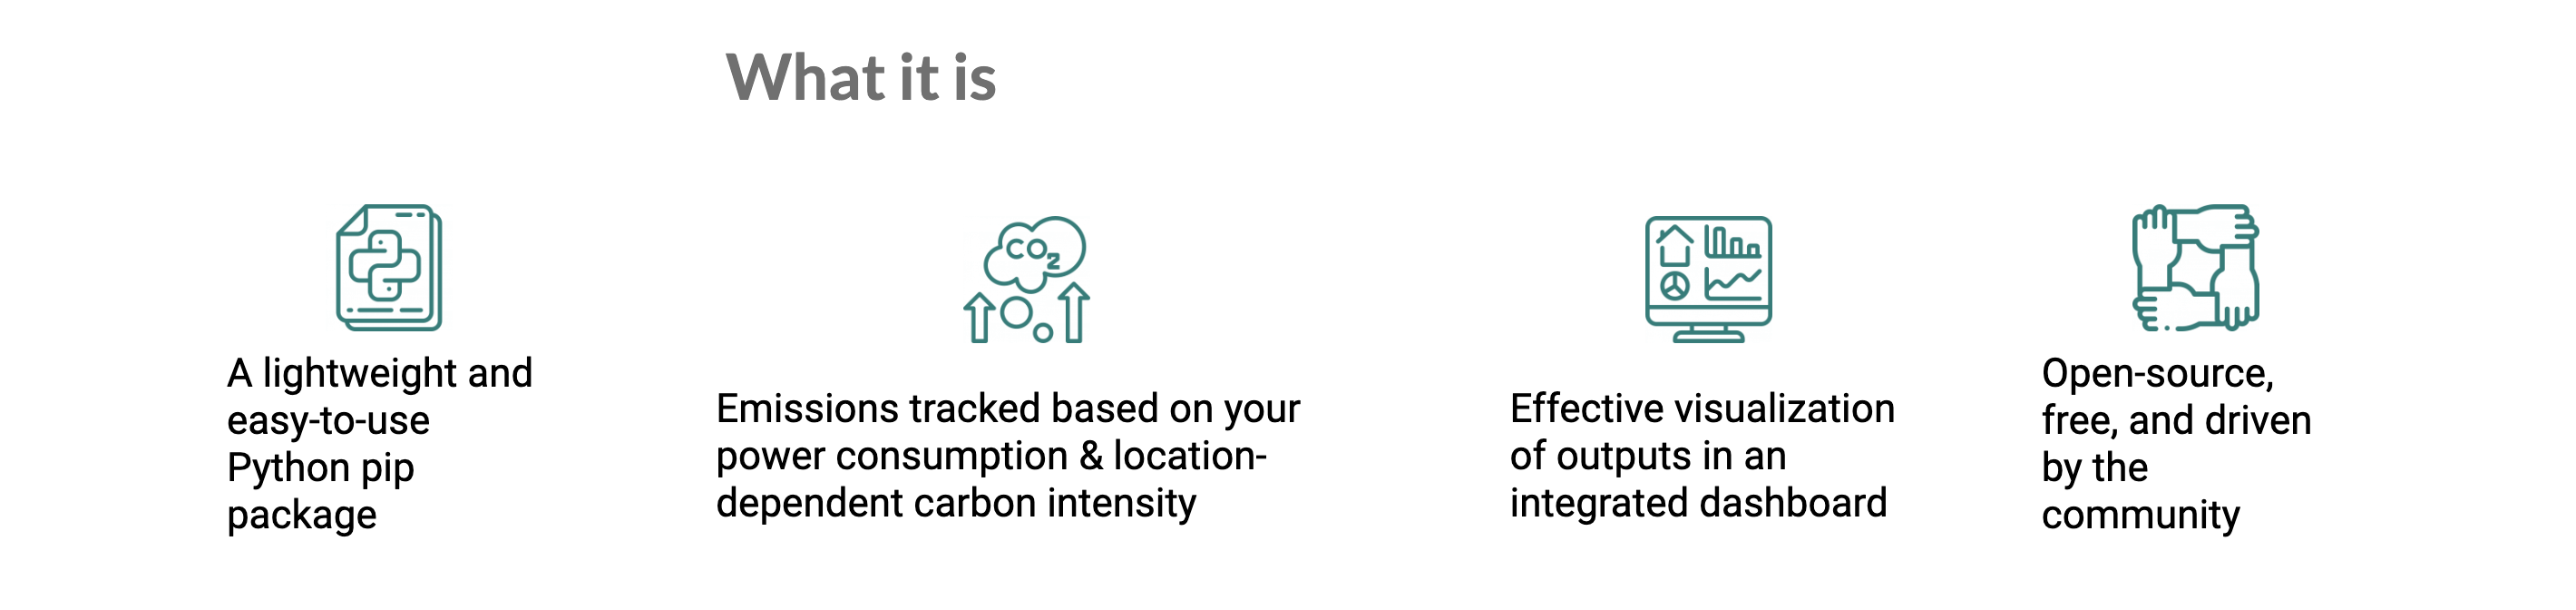

<font size=4> The tool __monitors tour computer's energy usage__ and cross references with regional __carbon cost of electricity__.

In [9]:
tracker = codecarbon.EmissionsTracker()
tracker.start()
# track carbon to do computation
v1 = np.random.random((1,10000))
v2 = np.random.random((10000,1))
print(f"Vector multiplication result: {v1 @ v2}")
co2 = tracker.stop()
print(f"Carbon cost [kg]: ", co2)

[codecarbon INFO @ 15:31:18] [setup] RAM Tracking...
[codecarbon INFO @ 15:31:18] [setup] GPU Tracking...
[codecarbon INFO @ 15:31:18] No GPU found.
[codecarbon INFO @ 15:31:18] [setup] CPU Tracking...
[codecarbon WARNING @ 15:31:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:31:19] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:31:19] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:31:19] >>> Tracker's metadata:
[codecarbon INFO @ 15:31:19]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:31:19]   Python version: 3.10.8
[codecarbon INFO @ 15:31:19]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:31:19]   CPU count: 8
[codecarbon INFO @ 15:31:19]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:31:19]   GPU count: None
[codecarbon INFO @ 15:31:19]   GPU mode

Vector multiplication result: [[2474.14801662]]
Carbon cost [kg]:  3.591901866771347e-09


<font size=4> Here is a function to make repeating training and testing easier!

In [10]:
def train_test_track_carbon(model, classification=False):
    tracker = codecarbon.EmissionsTracker()
    tracker.start()
    
    # train and test model
    if classification:
        metric = sklearn.metrics.accuracy_score
        dev_y = dev_y_class
        test_y = test_y_class
    else:
        metric = sklearn.metrics.mean_absolute_error
        dev_y = dev_y_regr
        test_y = test_y_regr
        
    # train model
    model.fit(dev_X, dev_y)
    
    # test the model
    preds = model.predict(test_X)
    score = metric(test_y, preds)
    co2 = tracker.stop()
    time.sleep(2)
    return score, co2

***

## 1. Linear Models 

<font size=4>One of the simplest models is to predict target using a linear combination of features:

<font size=5>$$\hat{f}(x_0, x_1,...,x_m)=b+\Sigma_{j=0}^mw_jx_j$$

- <font size=4> __Hyperparameters__: Which features $x_j$ to use.
    
- <font size=4> __Parameters__: Weights $w_j$ and bias $b$
    
- <font size=4> __Pros__: Low variance, does not require very large datasets, high intepretability
    
- <font size=4> __Cons__: High bias

### A. Multiple Linear Regression

<font size=4>Exactly described above. Regression tasks only.
    
<font size=4>[`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

- <font size=4> __Training of parameters__: Analytical Ordinary Least Squares

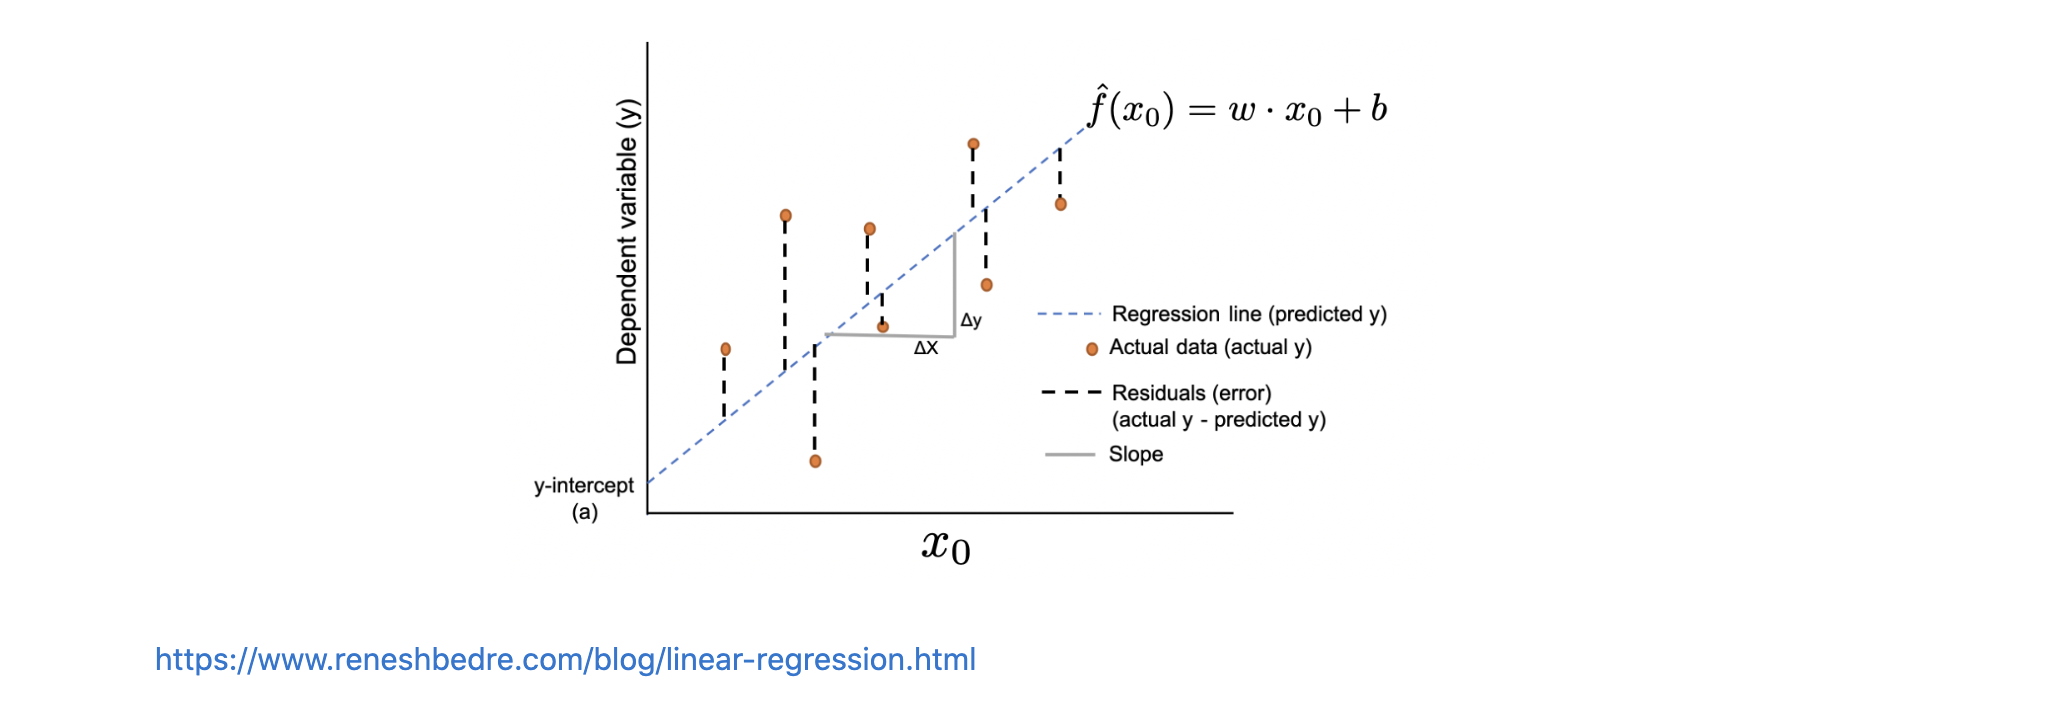

In [11]:
model = sklearn.linear_model.LinearRegression()
score, co2 = train_test_track_carbon(model)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 15:32:14] [setup] RAM Tracking...
[codecarbon INFO @ 15:32:14] [setup] GPU Tracking...
[codecarbon INFO @ 15:32:14] No GPU found.
[codecarbon INFO @ 15:32:14] [setup] CPU Tracking...
[codecarbon WARNING @ 15:32:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:32:16] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:32:16] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:32:16] >>> Tracker's metadata:
[codecarbon INFO @ 15:32:16]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:32:16]   Python version: 3.10.8
[codecarbon INFO @ 15:32:16]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:32:16]   CPU count: 8
[codecarbon INFO @ 15:32:16]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:32:16]   GPU count: None
[codecarbon INFO @ 15:32:16]   GPU mode

MSE: 0.09331128760938842, co2 [kg]: 7.787975206110817e-09


### B. Logistic Regression

<font size=4>Creates MLR model for each possible nominal target, and applies logistic function to the output to produce class probabilities. Classification only.
    
<font size=4>[`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

- <font size=4> __Training of parameters__: Numerical methods eg. Gradient descent (More in neural network notebook!)


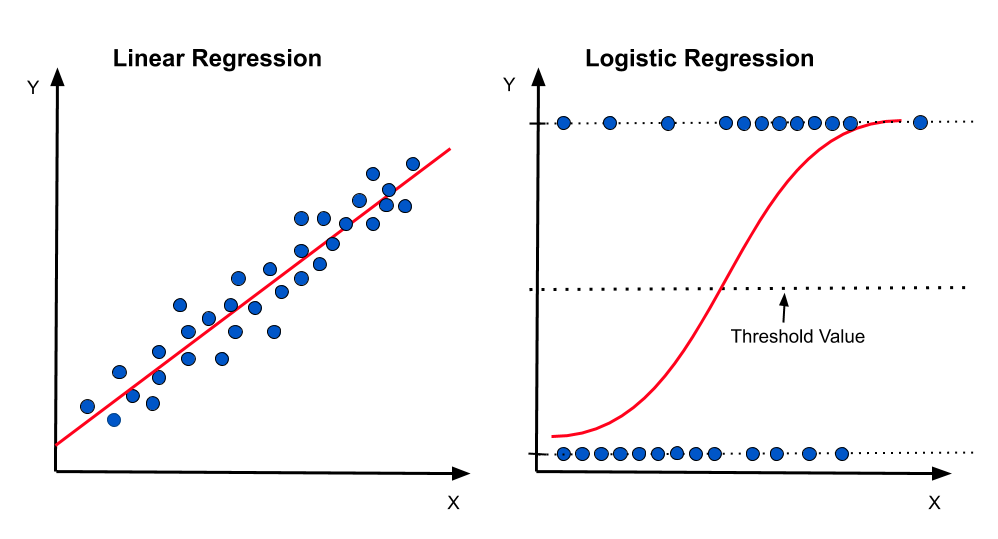

https://ai.plainenglish.io/why-is-logistic-regression-called-regression-if-it-is-a-classification-algorithm-9c2a166e7b74

In [17]:
model = sklearn.linear_model.LogisticRegression()
score, co2 = train_test_track_carbon(model, classification=True)
print(f'Accuracy: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 15:37:43] [setup] RAM Tracking...
[codecarbon INFO @ 15:37:43] [setup] GPU Tracking...
[codecarbon INFO @ 15:37:43] No GPU found.
[codecarbon INFO @ 15:37:43] [setup] CPU Tracking...
[codecarbon WARNING @ 15:37:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:37:44] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:37:44] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:37:44] >>> Tracker's metadata:
[codecarbon INFO @ 15:37:44]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:37:44]   Python version: 3.10.8
[codecarbon INFO @ 15:37:44]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:37:44]   CPU count: 8
[codecarbon INFO @ 15:37:44]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:37:44]   GPU count: None
[codecarbon INFO @ 15:37:44]   GPU mode

Accuracy: 0.9693333333333334, co2 [kg]: 3.248391142460959e-08


### C. Lasso Regression

<font size=4>Applies L1 regularization to Linear regression. Regression only. The penalty for weights using L1 regularization is the following:
    
<font size=5>$$\lambda \Sigma_j|w_j|$$

<font size=4>[`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

- <font size=4> __Training of parameters__: Analytical L1 Least Squares
    
- <font size=4> __Additional Hyperparameters__: $\lambda$ the strength of the regularization
    
- <font size=4> __Additional pros__: regularized, can be used for feature selection

In [12]:
model = sklearn.linear_model.Lasso(alpha=1.0)
score, co2 = train_test_track_carbon(model)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 15:32:34] [setup] RAM Tracking...
[codecarbon INFO @ 15:32:34] [setup] GPU Tracking...
[codecarbon INFO @ 15:32:34] No GPU found.
[codecarbon INFO @ 15:32:34] [setup] CPU Tracking...
[codecarbon WARNING @ 15:32:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:32:35] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:32:35] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:32:35] >>> Tracker's metadata:
[codecarbon INFO @ 15:32:35]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:32:35]   Python version: 3.10.8
[codecarbon INFO @ 15:32:35]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:32:35]   CPU count: 8
[codecarbon INFO @ 15:32:35]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:32:35]   GPU count: None
[codecarbon INFO @ 15:32:35]   GPU mode

MSE: 0.32789167155154764, co2 [kg]: 5.27216098762672e-09


### D. Ridge Regression

<font size=4>Applies L2 regularization to Linear regression. Regression only. The penalty for weights using L2 regularization is the following:
    
<font size=5>$$\lambda \Sigma_jw_j^2$$

<font size=4>[`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

- <font size=4> __Training of parameters__: Analytical L2 Least Squares
    
- <font size=4> __Additional Hyperparameters__: $\lambda$ the strength of the regularization
    
- <font size=4> __Additional pros__: regularized, can be used for feature selection

In [13]:
model = sklearn.linear_model.Ridge(alpha=1.0)
score, co2 = train_test_track_carbon(model)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 15:33:43] [setup] RAM Tracking...
[codecarbon INFO @ 15:33:43] [setup] GPU Tracking...
[codecarbon INFO @ 15:33:43] No GPU found.
[codecarbon INFO @ 15:33:43] [setup] CPU Tracking...
[codecarbon WARNING @ 15:33:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:33:44] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:33:44] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:33:44] >>> Tracker's metadata:
[codecarbon INFO @ 15:33:44]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:33:44]   Python version: 3.10.8
[codecarbon INFO @ 15:33:44]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:33:44]   CPU count: 8
[codecarbon INFO @ 15:33:44]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:33:44]   GPU count: None
[codecarbon INFO @ 15:33:44]   GPU mode

MSE: 0.09329142252786832, co2 [kg]: 5.30724964307176e-09


## 2. K-Nearest Neighbor

<font size=4>Determines target by averaging over the target values of the nearest K training datpoints in feature space.

<font size=4>[`sklearn.neighbors.KNeighborClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
    
<font size=4>[`sklearn.neighbors.KNeighborRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)

- <font size=4> __Hyperparameters__: Features used, Number of Neighbors, type of distance (eg euclidean)
    
- <font size=4> __Parameters__: Training data
    
- <font size=4> __Pros__: No assumptions of functional form, intuitive
    
- <font size=4> __Cons__: Does not scale well with number of datapoints and number of features

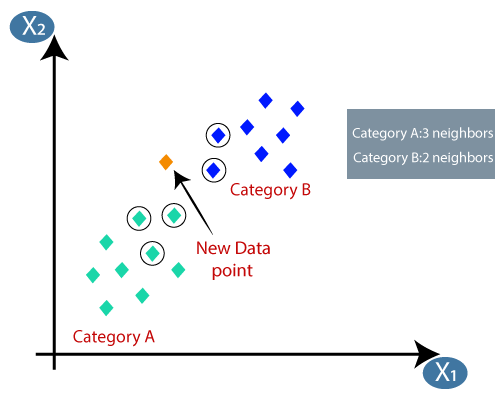

https://www.javatpoint.com/k-nearest-neighbor-algorithm-for-machine-learning

In [14]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10)
score, co2 = train_test_track_carbon(model, classification=True)
print(f'Accuracy: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 15:34:06] [setup] RAM Tracking...
[codecarbon INFO @ 15:34:06] [setup] GPU Tracking...
[codecarbon INFO @ 15:34:06] No GPU found.
[codecarbon INFO @ 15:34:06] [setup] CPU Tracking...
[codecarbon WARNING @ 15:34:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:34:08] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:34:08] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:34:08] >>> Tracker's metadata:
[codecarbon INFO @ 15:34:08]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:34:08]   Python version: 3.10.8
[codecarbon INFO @ 15:34:08]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:34:08]   CPU count: 8
[codecarbon INFO @ 15:34:08]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:34:08]   GPU count: None
[codecarbon INFO @ 15:34:08]   GPU mode

Accuracy: 0.984, co2 [kg]: 4.1713156731309553e-08


## 3. Decision Trees

<font size=4>Sequentially partitions data based on feature thresholds, chosing thresholds to maximally seperate the data. Effective for classification and regression.

<font size=4>[`sklearn.tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
    
<font size=4>[`sklearn.tree.DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

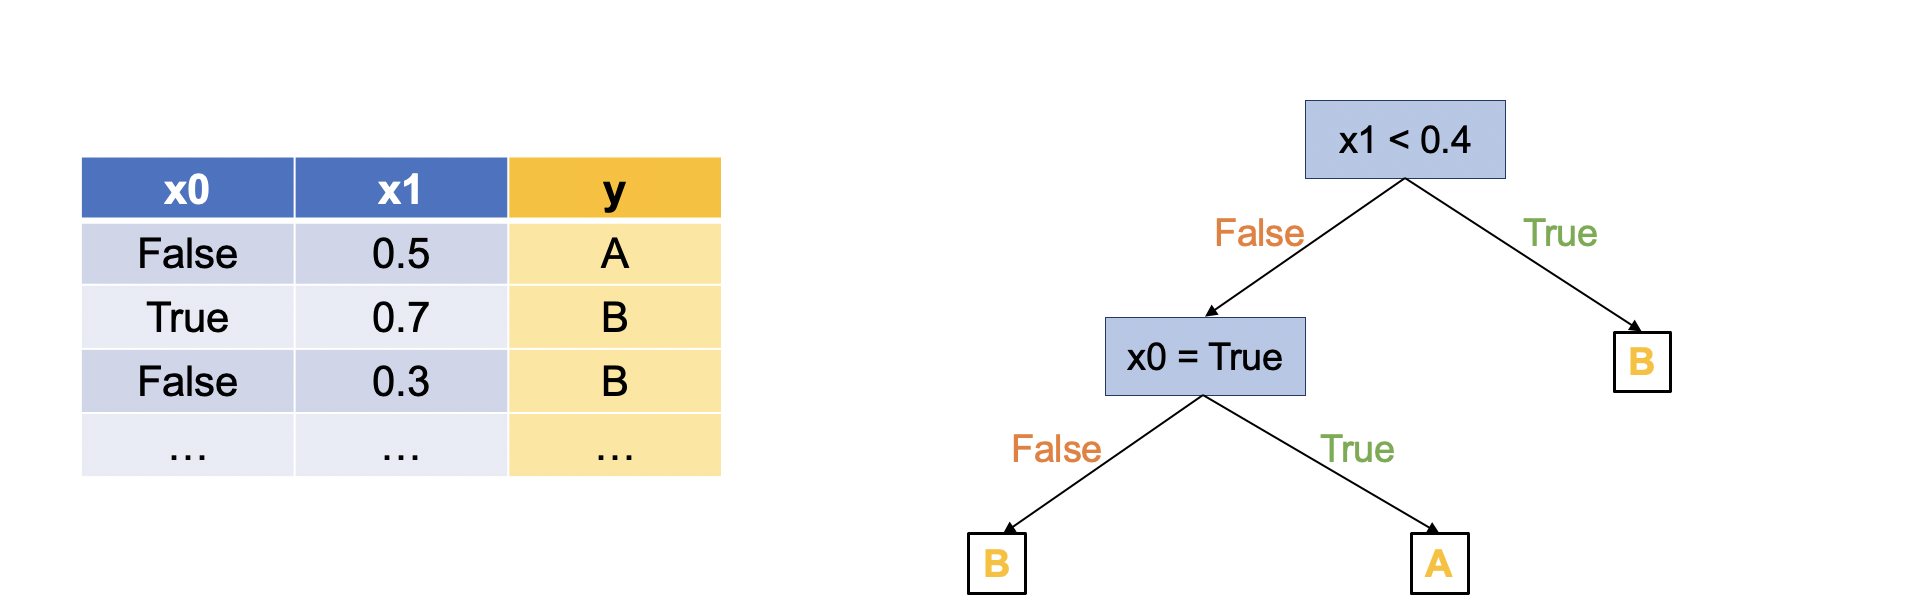

<font size=4> Note: __Branching is not in any particular feature order.__ Branches will be chosen to maximally seperate data into groups, and it may use the same feature with different thresholds at different points in the tree - Eg. split the data broadly by a feature early on, but use the same feature much lower in the tree to make a more precise decision.

- <font size=4> __Hyperparameters__: Features used, depth of tree, factors affecting leaf and branch decisionmaking such as minimum number of training examples on each side of a decision.
    
- <font size=4> __Training__: Information gain optimization
    
- <font size=4> __Parameters__: Hyperplane
    
- <font size=4> __Pros__: Intuitive and very flexible
    
- <font size=4> __Cons__: Very prone to overfitting

In [16]:
model = sklearn.tree.DecisionTreeClassifier()
score, co2 = train_test_track_carbon(model, classification=True)
print(f'Accuracy: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 15:35:34] [setup] RAM Tracking...
[codecarbon INFO @ 15:35:34] [setup] GPU Tracking...
[codecarbon INFO @ 15:35:34] No GPU found.
[codecarbon INFO @ 15:35:34] [setup] CPU Tracking...
[codecarbon WARNING @ 15:35:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:35:36] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:35:36] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:35:36] >>> Tracker's metadata:
[codecarbon INFO @ 15:35:36]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:35:36]   Python version: 3.10.8
[codecarbon INFO @ 15:35:36]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:35:36]   CPU count: 8
[codecarbon INFO @ 15:35:36]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:35:36]   GPU count: None
[codecarbon INFO @ 15:35:36]   GPU mode

Accuracy: 0.988, co2 [kg]: 2.394598531642633e-08


### A. Random Forest

<font size=4>Bags __data and features__ to create many decision trees. Use as an ensemble.

<font size=4>[`sklearn.tree.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
    
<font size=4>[`sklearn.tree.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

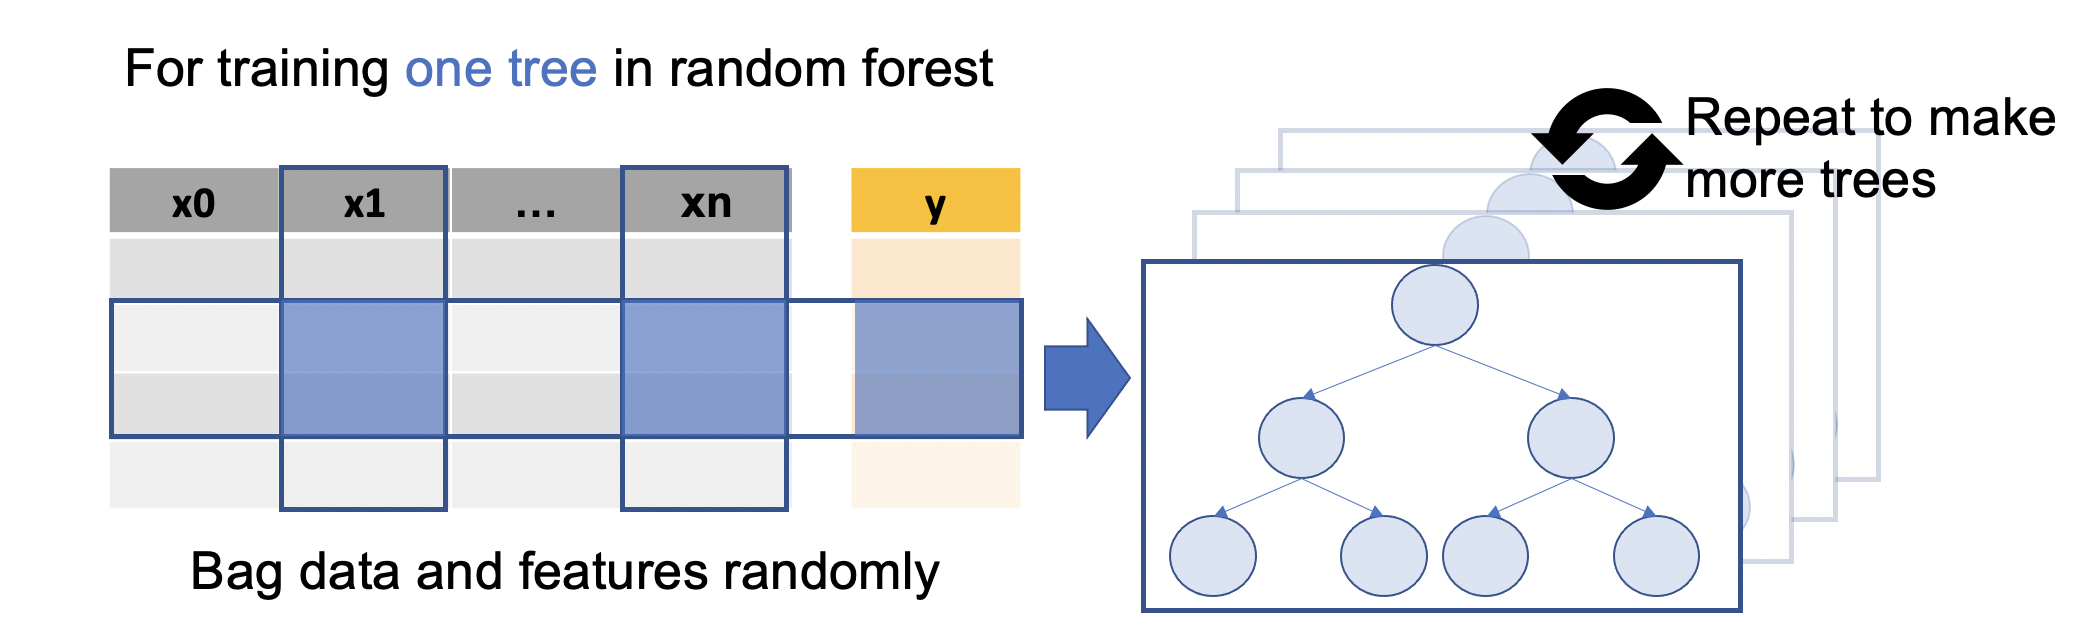

- <font size=4> __Additional Hyperparameters__: Forest size, bagging sizes
    
- <font size=4> __Training__: Repeat decision tree training for ensemble
    
- <font size=4> __Additional Pros__: Significantly reduces model overfitting.
    
- <font size=4> __Additional Cons__: can be expensive to train

In [21]:
model = sklearn.ensemble.RandomForestRegressor()
score, co2 = train_test_track_carbon(model, classification=False)
print(f'MAE: {score}, co2 [kg]: {co2}')

[codecarbon INFO @ 15:41:29] [setup] RAM Tracking...
[codecarbon INFO @ 15:41:29] [setup] GPU Tracking...
[codecarbon INFO @ 15:41:29] No GPU found.
[codecarbon INFO @ 15:41:29] [setup] CPU Tracking...
[codecarbon WARNING @ 15:41:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:41:30] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:41:30] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:41:30] >>> Tracker's metadata:
[codecarbon INFO @ 15:41:30]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:41:30]   Python version: 3.10.8
[codecarbon INFO @ 15:41:30]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:41:30]   CPU count: 8
[codecarbon INFO @ 15:41:30]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:41:30]   GPU count: None
[codecarbon INFO @ 15:41:30]   GPU mode

MAE: 0.0067398197008679, co2 [kg]: 9.542212483222618e-07


### B. _Exercise_: Cost of Random Forest

<font size=4> I mentioned that RFs can be expensive to train - consider the following three hyperparameters: 
    
<font size=4> - `n_estimators`

<font size=4> - `max_depth`
    
<font size=4> - `max_features`
    
<font size=4> __Choose one__ of these hyperparameters to conduct a study on. Test out different values of the hyperparameter, and record the carbon cost for training and prediction. Ensure someone at your table is doing each hyperparameter. How does the hyperparameter effect the carbon cost? A plot may be helpful.

> <span style='color:red'>remove for lecture

In [25]:
co2s = []
n_estimators_list = [5, 10, 100, 1000]
for n_estimators in n_estimators_list:
    model = sklearn.ensemble.RandomForestRegressor(n_estimators=n_estimators)
    _, co2 = train_test_track_carbon(model, classification=False)
    co2s.append(co2)

[codecarbon INFO @ 15:45:33] [setup] RAM Tracking...
[codecarbon INFO @ 15:45:33] [setup] GPU Tracking...
[codecarbon INFO @ 15:45:33] No GPU found.
[codecarbon INFO @ 15:45:33] [setup] CPU Tracking...
[codecarbon WARNING @ 15:45:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:45:35] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:45:35] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:45:35] >>> Tracker's metadata:
[codecarbon INFO @ 15:45:35]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:45:35]   Python version: 3.10.8
[codecarbon INFO @ 15:45:35]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:45:35]   CPU count: 8
[codecarbon INFO @ 15:45:35]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:45:35]   GPU count: None
[codecarbon INFO @ 15:45:35]   GPU mode

Text(0, 0.5, 'Carbon [kg]')

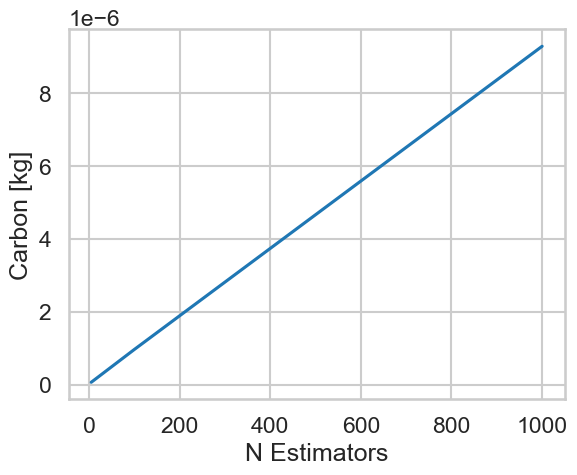

In [27]:
fig, ax = plt.subplots()
ax.plot(n_estimators_list, co2s)
# ax.set_yscale('log')
ax.set_xlabel('N Estimators')
ax.set_ylabel('Carbon [kg]')

In [28]:
co2s = []
max_depth_list = [5, 10, 100, 1000]
for max_depth in max_depth_list:
    model = sklearn.ensemble.RandomForestRegressor(max_depth=max_depth)
    _, co2 = train_test_track_carbon(model, classification=False)
    co2s.append(co2)

[codecarbon INFO @ 15:51:07] [setup] RAM Tracking...
[codecarbon INFO @ 15:51:07] [setup] GPU Tracking...
[codecarbon INFO @ 15:51:07] No GPU found.
[codecarbon INFO @ 15:51:07] [setup] CPU Tracking...
[codecarbon WARNING @ 15:51:07] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:51:08] We saw that you have a Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:51:08] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:51:08] >>> Tracker's metadata:
[codecarbon INFO @ 15:51:08]   Platform system: macOS-10.15.7-x86_64-i386-64bit
[codecarbon INFO @ 15:51:08]   Python version: 3.10.8
[codecarbon INFO @ 15:51:08]   Available RAM : 8.000 GB
[codecarbon INFO @ 15:51:08]   CPU count: 8
[codecarbon INFO @ 15:51:08]   CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
[codecarbon INFO @ 15:51:08]   GPU count: None
[codecarbon INFO @ 15:51:08]   GPU mode

<font size=4>10 times the models in the ensemble means 10 times the cost

### B. Support Vector Machine

<font size=4>Draws a hyperplane to maximally seperate data in a new kernel space. Classification originally, but extended for regression cases.

<font size=4>[`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
    
<font size=4>[`sklearn.svm.SVR`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)

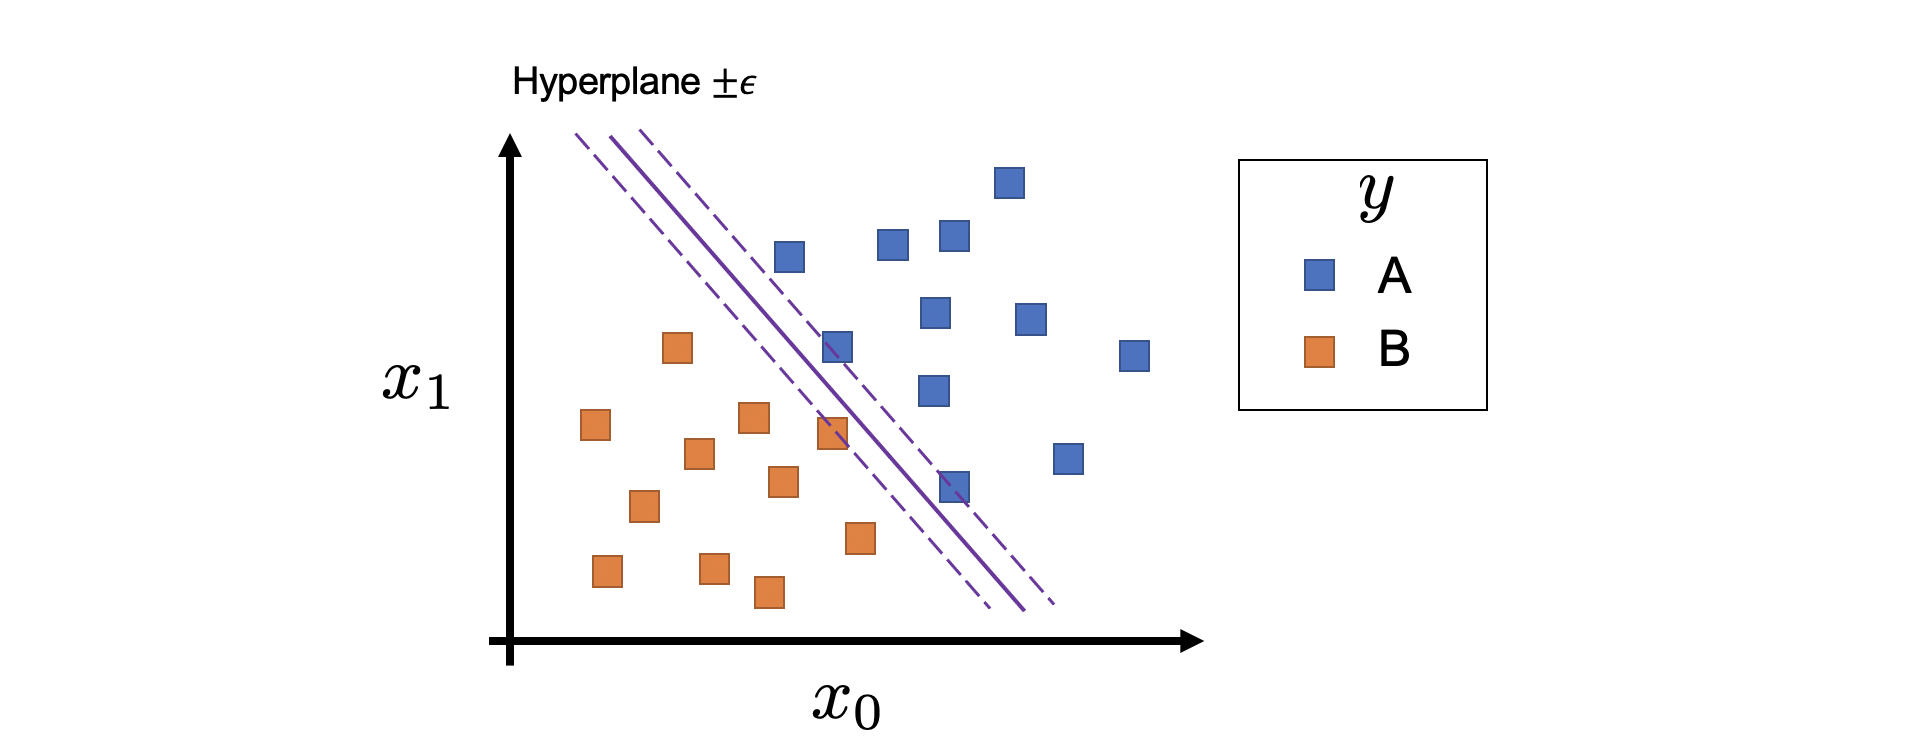

- <font size=4> __Hyperparameters__: Features used, kernel used, type of distance, $\epsilon$
    
- <font size=4> __Training__: Convex optimization of hyperplane to maximally seperate data
    
- <font size=4> __Parameters__: Hyperplane
    
- <font size=4> __Pros__: Very flexible, effective for high dimensions (many features)
    
- <font size=4> __Cons__: Prohibitively expensive to train for large datasets, sensitive to overfitting to noise